One our trading strategies requires forecasts of volatility (= std dev of returns, returns typically mean log returns i.e. log(P(t)) - log(P(t-1)). 
So we are always looking for an edge here. I have attached a recently published paper on predicting volatility using a LASSO regression. 
LASSO stands for Least Absolute Shrinkage and Selection Operator and is just regression with L1 penalty. It is useful in stabilising parameter estimates as it produces sparse parameter estimates (exact zeros as opposed to small values). 

I have attached sample of crypto data as well. prices.csv has prices sampled every 30 minutes of 20 currencies. bid & ask.csv contain bid and ask volumes from order book snapshots at 30 min frequency and logvoldiff.csv contains log(bid/ask). Timestamps of all files should already be aligned, but it is good to check and make sure of it.

In [ ]:
# requirements.txt
# numpy
# pandas 
# pickle
# statsmodels
# matplotlib
# pandas_profiling 
# scikit-learn

##### Imports

In [1]:
# Import packages
## Currently used conda environment for local system: (defi)
import os
import sys
import math
import time
import json
import random
import requests
import numpy as np
import pandas as pd
from pickle import dump
from random import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas_profiling import ProfileReport
from statsmodels.tsa.ar_model import AutoReg
from pandas_visual_analysis import VisualAnalysis
from statsmodels.tsa.stattools  import   grangercausalitytests
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib inline 


In [2]:
prices_df     = pd.read_csv('data/prices.csv')
logvoldiff_df = pd.read_csv('data/logvoldiff.csv')
bid_df        = pd.read_csv('data/bid.csv')
ask_df        = pd.read_csv('data/ask.csv')

In [3]:
print("Prices DF shape:     ", prices_df.shape)
print("LogVolDiff DF shape: ", logvoldiff_df.shape)
print("BID DF shape:        ", bid_df.shape)
print("ASK DF shape:        ", ask_df.shape)

Prices DF shape:      (11073, 20)
LogVolDiff DF shape:  (11073, 20)
BID DF shape:         (11073, 20)
ASK DF shape:         (11073, 20)


##### Head

In [4]:
prices_df.head()

datetime   1inch     aave      ada     akro    algo  alice  \
0  2021-02-19T08:00:00.0  4.7542  439.055  0.91666  0.04471  1.3654    NaN   
1  2021-02-19T08:30:00.0  4.7000  434.838  0.91388  0.04509  1.3560    NaN   
2  2021-02-19T09:00:00.0  4.7258  434.984  0.92215  0.04497  1.3517    NaN   
3  2021-02-19T09:30:00.0  4.7780  435.156  0.92490  0.04522  1.3429    NaN   
4  2021-02-19T10:00:00.0  4.7962  445.831  0.92963  0.04546  1.3485    NaN   

     alpha      ankr    atom     avax      axs  bake     bal     band     bat  \
0  1.57621  0.028639  22.891  39.9466  2.06247   NaN  45.065  18.3171  0.6339   
1  1.58928  0.028604  22.785  39.8489  2.04111   NaN  44.680  18.1848  0.6292   
2  1.58835  0.028261  22.884  39.9780  2.02166   NaN  44.822  18.1623  0.6263   
3  1.58173  0.028547  22.905  40.2996  2.02160   NaN  45.296  18.1279  0.6256   
4  1.59146  0.028214  23.070  39.9801  2.02303   NaN  45.080  18.0971  0.6269   

      bch      bel      blz      bnb  
0  717.84  3.31458  0.23481  261.463  
1  716.30  3.32453  0.23455  264.435  
2  718.72  3.34409  0.23266  259.077  
3  723.66  3.39550  0.23088  257.117  
4  719.29  3.43782  0.23037  253.851

In [5]:
logvoldiff_df.head()

datetime     1inch      aave       ada      akro      algo  \
0  2021-02-19T08:00:00.0 -0.381070 -0.570268 -0.696489 -0.432198 -0.745933   
1  2021-02-19T08:30:00.0 -0.417633 -0.534572 -0.675488 -0.566383 -0.746187   
2  2021-02-19T09:00:00.0 -0.409775 -0.560603 -0.513017 -0.696060 -0.765916   
3  2021-02-19T09:30:00.0 -0.423772 -0.552330 -0.517075 -0.576636 -0.666946   
4  2021-02-19T10:00:00.0 -0.400131 -0.483094 -0.539655 -0.654939 -0.722611   

   alice     alpha      ankr      atom      avax       axs  bake       bal  \
0    NaN -0.509360 -0.433220 -0.723376 -0.671961 -1.056694   NaN -0.070798   
1    NaN -0.591515 -0.425895 -0.767384 -0.735183 -0.745598   NaN -0.080595   
2    NaN -0.515332 -0.287728 -0.724365 -0.717836 -0.636407   NaN -0.041614   
3    NaN -0.566608 -0.386602 -0.659886 -0.841154 -0.696903   NaN -0.183602   
4    NaN -0.561985 -0.313959 -0.795961 -0.716354 -0.534406   NaN -0.170173   

       band       bat       bch       bel       blz       bnb  
0 -0.963707 -0.757443 -0.738702 -1.047817 -0.713145 -0.921996  
1 -0.841567 -0.962213 -0.648845 -1.106495 -0.619305 -0.979828  
2 -0.765406 -0.839286 -0.713020 -1.169182 -0.450443 -0.515056  
3 -0.781982 -0.785809 -0.738093 -0.564054 -0.232146 -0.213231  
4 -0.853630 -0.847093 -0.749924 -0.481151 -0.240538  0.230705

In [6]:
bid_df.head()

datetime      1inch      aave         ada       akro  \
0  2021-02-19T08:00:00.0  405179.28  5144.433  11745019.0  5452048.0   
1  2021-02-19T08:30:00.0  424065.47  4810.717  11905728.0  5387921.0   
2  2021-02-19T09:00:00.0  425580.50  4920.693  14538797.0  5391057.0   
3  2021-02-19T09:30:00.0  424005.72  5162.695  14624187.0  5806053.0   
4  2021-02-19T10:00:00.0  423718.00  6194.617  14271959.0  5909754.0   

        algo  alice     alpha        ankr       atom      avax       axs  \
0  1083852.2    NaN  762661.1  12790988.0  57517.312  44271.92   80023.4   
1  1091956.1    NaN  742122.7  12568366.0  55536.656  43566.38   97341.3   
2  1049185.5    NaN  753528.6  13352848.0  59138.223  45508.39  101556.1   
3  1183722.1    NaN  712967.7  12652284.0  65867.266  42515.15   94535.7   
4  1149395.8    NaN  744019.0  12941721.0  60673.324  44888.92  112087.8   

   bake       bal      band         bat        bch        bel        blz  \
0   NaN  8360.846  45678.14  1191381.20  6055.6330   94447.93   908298.1   
1   NaN  8701.479  50296.96   937463.06  6605.3790   91689.65   974027.2   
2   NaN  8863.599  53158.51  1032327.40  6515.4575   89279.98  1026148.5   
3   NaN  8119.536  54221.88  1073554.40  6418.5635  155336.47  1245937.6   
4   NaN  8033.560  50155.56  1043204.00  5883.1055  165294.11  1240857.2   

         bnb  
0  52010.895  
1  50816.164  
2  75064.870  
3  79846.480  
4  87757.290

In [7]:
ask_df.head()

datetime      1inch       aave         ada        akro  \
0  2021-02-19T08:00:00.0  593121.80   9099.168  23568676.0   8399646.0   
1  2021-02-19T08:30:00.0  643885.20   8210.533  23394654.0   9492883.0   
2  2021-02-19T09:00:00.0  641127.80   8619.716  24284492.0  10813567.0   
3  2021-02-19T09:30:00.0  647759.06   8969.127  24526438.0  10335010.0   
4  2021-02-19T10:00:00.0  632196.00  10041.981  24482342.0  11376427.0   

        algo  alice      alpha        ankr       atom      avax       axs  \
0  2285202.8    NaN  1269239.9  19726456.0  118565.06  86687.68  230214.8   
1  2302874.2    NaN  1340810.4  19241672.0  119632.88  90873.50  205166.4   
2  2256759.0    NaN  1261553.6  17804618.0  122027.04  93291.84  191908.4   
3  2306219.5    NaN  1256447.6  18623788.0  127424.91  98594.44  189782.9   
4  2367529.8    NaN  1305121.1  17715064.0  134486.62  91885.64  191270.4   

   bake       bal       band        bat        bch        bel        blz  \
0   NaN  8974.231  119740.44  2540995.2  12675.752  269310.80  1853289.0   
1   NaN  9431.813  116688.87  2453792.0  12638.262  277245.88  1809388.9   
2   NaN  9240.228  114283.77  2389543.2  13292.461  287424.10  1610034.0   
3   NaN  9755.923  118518.21  2355573.5  13427.263  273048.10  1571505.9   
4   NaN  9523.862  117773.02  2433643.5  12453.594  267435.20  1578288.0   

          bnb  
0  130771.230  
1  135374.220  
2  125638.440  
3   98823.660  
4   69676.984

##### Describe

In [8]:
prices_df.describe()

1inch          aave           ada          akro          algo  \
count  11066.000000  11066.000000  11066.000000  11066.000000  11066.000000   
mean       3.632859    356.759867      1.621133      0.035562      1.194554   
std        1.214028     74.397585      0.523570      0.016781      0.346077   
min        1.634000    172.980000      0.857790      0.013730      0.680800   
25%        2.682025    305.800000      1.222355      0.022360      0.911625   
50%        3.261800    361.532500      1.397830      0.029940      1.104050   
75%        4.388800    398.905000      2.030350      0.046960      1.379075   
max        7.798800    661.450000      3.095700      0.088140      2.506300   

             alice         alpha          ankr          atom          avax  \
count  9876.000000  11065.000000  11065.000000  11066.000000  11065.000000   
mean     10.991685      1.168591      0.098600     19.797944     29.667076   
std       4.396604      0.498233      0.038588      7.718426     16.593355   
min       3.244000      0.310500      0.020966      8.041000      9.348000   
25%       6.724000      0.770400      0.073137     13.217000     14.842000   
50%      12.039000      1.089700      0.095700     19.274000     27.947600   
75%      13.803500      1.617050      0.118730     22.957000     36.997000   
max      24.100000      2.489600      0.208714     44.270000     78.657000   

                axs         bake           bal          band           bat  \
count  11066.000000  6797.000000  11066.000000  11066.000000  11065.000000   
mean      27.102488     2.470728     35.485114     10.520494      0.832479   
std       31.583838     0.773077     15.794243      4.298629      0.278544   
min        1.153770     1.425100     13.807000      4.160900      0.408600   
25%        4.516000     1.904100     22.250250      7.054325      0.619600   
50%        8.000500     2.136400     28.659500      8.912800      0.748300   
75%       55.477500     2.884800     50.824000     14.153025      1.061700   
max      152.670000     5.790300     74.956000     23.206600      1.646000   

                bch           bel           blz           bnb  
count  11065.000000  11066.000000  11066.000000  11065.000000  
mean     650.350047      2.469379      0.268700    382.524173  
std      212.250951      1.119567      0.118424    110.498838  
min      385.730000      0.881300      0.111300    193.797000  
25%      516.830000      1.659325      0.177090    299.440000  
50%      593.780000      2.044250      0.229910    353.080000  
75%      682.840000      3.208505      0.365400    442.090000  
max     1601.420000      5.803290      0.635860    690.032000

In [9]:
logvoldiff_df.describe()

1inch          aave           ada          akro          algo  \
count  11066.000000  11066.000000  11066.000000  11064.000000  11066.000000   
mean      -0.027384     -0.062013     -0.012261     -0.076468     -0.142118   
std        0.543711      0.706416      0.572566      0.522998      0.445799   
min       -1.519339     -1.842721     -8.311922     -1.773167     -1.379521   
25%       -0.419714     -0.527583     -0.337036     -0.463833     -0.471674   
50%       -0.072929     -0.151427     -0.024240     -0.086097     -0.171676   
75%        0.337364      0.284148      0.250796      0.304735      0.145833   
max        4.176857      4.066976      7.689294      2.413576      1.688919   

             alice         alpha          ankr          atom          avax  \
count  9883.000000  11066.000000  11066.000000  11064.000000  11066.000000   
mean      0.028782      0.053883     -0.030727     -0.064828      0.020334   
std       0.596140      0.636100      0.438173      0.583286      0.623489   
min      -1.557077     -2.003397     -1.382945     -1.453198     -2.511963   
25%      -0.372941     -0.374646     -0.356215     -0.463768     -0.388832   
50%      -0.029594      0.001291     -0.019219     -0.113400      0.017545   
75%       0.332123      0.457331      0.272624      0.227940      0.395951   
max       3.268393      4.328827      1.787319      8.129616      6.044994   

                axs         bake           bal          band           bat  \
count  11056.000000  6767.000000  11066.000000  11063.000000  11066.000000   
mean      -0.102266     0.078532      0.177297     -0.013245      0.099043   
std        0.638283     0.509923      0.491614      0.573214      0.445853   
min       -1.833251    -1.774491     -2.136832     -1.647647     -1.243785   
25%       -0.535682    -0.261754     -0.144851     -0.407704     -0.224187   
50%       -0.132398     0.069883      0.183584     -0.047054      0.080669   
75%        0.341307     0.390771      0.494899      0.340123      0.397467   
max        2.209917     2.724382      2.075596      6.691777      5.699339   

                bch           bel           blz           bnb  
count  11066.000000  11063.000000  11058.000000  11066.000000  
mean      -0.009238     -0.256857     -0.197017     -0.176938  
std        0.509279      0.577475      0.551749      0.614938  
min       -5.758232     -2.105939     -1.842816     -5.609552  
25%       -0.278513     -0.644780     -0.583672     -0.465915  
50%       -0.029052     -0.247536     -0.205531     -0.164268  
75%        0.235959      0.121748      0.147550      0.134423  
max        6.046710      2.126311      2.140637      7.269009

In [10]:
bid_df.describe()

1inch           aave           ada          akro          algo  \
count  1.106600e+04   11066.000000  1.106600e+04  1.106400e+04  1.106600e+04   
mean   4.017044e+05    9139.293385  1.485640e+07  9.303001e+06  1.573986e+06   
std    1.198112e+05   27631.403627  4.592379e+06  3.649844e+06  5.750711e+05   
min    7.429600e+04     863.168000  1.308070e+03  3.042897e+05  3.042897e+05   
25%    3.217836e+05    4859.468675  1.196717e+07  6.701166e+06  1.227477e+06   
50%    3.930002e+05    5757.373150  1.448985e+07  9.023102e+06  1.460825e+06   
75%    4.649330e+05    7594.111250  1.715753e+07  1.121143e+07  1.771680e+06   
max    2.039662e+06  469138.060000  4.411537e+07  7.016354e+07  6.295695e+06   

              alice         alpha          ankr           atom           avax  \
count    9883.00000  1.106600e+04  1.106600e+04   11064.000000   11066.000000   
mean   177759.55906  9.539101e+05  6.572620e+06  106602.204221  105427.050193   
std     93729.47075  7.115550e+05  4.146763e+06   44340.390824   52349.145293   
min     22022.00000  1.015469e+05  3.042897e+05   12048.203000    1464.750000   
25%    115163.02500  5.763373e+05  4.139125e+06   81433.145000   73742.072000   
50%    163110.67000  7.596491e+05  5.016491e+06   98577.523000   92020.525000   
75%    217975.45500  1.064280e+06  6.836916e+06  119342.412000  125310.490000   
max    683335.56000  1.071817e+07  4.427870e+07  469138.060000  491337.500000   

                 axs          bake            bal           band  \
count   11056.000000  6.767000e+03   11066.000000   11063.000000   
mean   126345.603389  8.117333e+05   12080.526187   71830.673749   
std     79441.589827  3.202442e+05   26057.752817   36114.571932   
min     16179.260000  1.362150e+05    1453.142000   13967.024000   
25%     75317.950000  5.832159e+05    7068.159500   55105.687000   
50%    106328.750000  7.470538e+05    9318.461500   65681.260000   
75%    151160.232500  9.789914e+05   12905.005250   79230.300000   
max    811214.500000  2.648646e+06  469138.060000  469138.060000   

                bat            bch            bel           blz            bnb  
count  1.106600e+04   11066.000000   11063.000000  1.105800e+04   11066.000000  
mean   1.026790e+06    6357.773782  132010.335082  1.265626e+06   64643.914704  
std    2.975515e+05   26069.927556   58956.208261  4.803655e+05   32454.228382  
min    2.389854e+05       9.127770   21903.570000  1.493350e+05     143.295000  
25%    8.219303e+05    3784.031450   90197.465000  9.540026e+05   48338.237500  
50%    9.934210e+05    4480.982500  122573.140000  1.210079e+06   62385.521500  
75%    1.192812e+06    5381.475250  158956.015000  1.493525e+06   77111.717500  
max    2.892941e+06  469138.060000  590901.500000  1.384628e+07  469138.060000

In [11]:
ask_df.describe()

1inch           aave           ada          akro          algo  \
count  1.106600e+04   11066.000000  1.106600e+04  1.106400e+04  1.106600e+04   
mean   4.516273e+05    8856.420772  1.576735e+07  1.059634e+07  1.930822e+06   
std    2.254693e+05   23179.162771  6.814570e+06  5.359035e+06  8.849893e+05   
min    7.374510e+03     704.576600  7.077270e+03  2.784915e+05  1.983759e+05   
25%    2.834700e+05    5032.824825  1.093763e+07  6.676752e+06  1.185143e+06   
50%    4.066144e+05    6791.155500  1.444987e+07  9.721528e+06  1.836664e+06   
75%    5.942797e+05    8847.801250  2.000327e+07  1.333905e+07  2.567082e+06   
max    1.432314e+06  427054.700000  4.981266e+07  3.667462e+07  5.369099e+06   

               alice         alpha          ankr           atom  \
count    9883.000000  1.106600e+04  1.106600e+04   11064.000000   
mean   190187.323080  8.769041e+05  7.450261e+06  122459.418294   
std    126895.989998  4.448702e+05  5.505056e+06   60276.710249   
min      3761.540000  5.892062e+04  2.784915e+05      15.645000   
25%     95036.920000  5.473612e+05  3.369481e+06   76857.557500   
50%    150266.690000  7.982124e+05  5.595680e+06  111313.245000   
75%    260155.430000  1.150488e+06  9.660018e+06  160234.995000   
max    791298.400000  4.170042e+06  5.934461e+07  431402.280000   

                avax            axs          bake            bal  \
count   11066.000000   11056.000000  6.767000e+03   11066.000000   
mean   114120.247630  147155.717062  7.894311e+05   11228.715341   
std     76479.171587   94249.855727  3.740841e+05   23928.173916   
min       145.140000    6275.250000  5.135660e+04     403.016000   
25%     61460.365250   74796.810000  5.046728e+05    5072.994750   
50%     89636.550000  125351.045000  7.438708e+05    8120.666500   
75%    143046.042500  200979.750000  1.014063e+06   11920.107000   
max    535979.250000  683335.300000  2.096774e+06  427054.700000   

                band           bat            bch            bel  \
count   11063.000000  1.106600e+04   11066.000000   11063.000000   
mean    77662.026671  9.941754e+05    6402.540941  184558.484794   
std     42138.505373  4.612987e+05   23156.426683  112588.830770   
min        58.040000  2.602240e+03      13.403240    5768.790000   
25%     47508.715000  6.326055e+05    3573.427900  104679.470000   
50%     69920.020000  9.026285e+05    4559.775500  161781.250000   
75%     97106.820500  1.281127e+06    5841.693750  237852.230000   
max    427054.700000  3.615176e+06  427054.700000  812778.440000   

                blz            bnb  
count  1.105800e+04   11066.000000  
mean   1.662406e+06   78627.438365  
std    8.508690e+05   38000.131862  
min    3.721900e+04      31.000000  
25%    1.022559e+06   53351.499000  
50%    1.528208e+06   71431.950000  
75%    2.136183e+06   98788.586000  
max    5.376066e+06  427054.700000

#####  Technical Indicators Theory

1) Moving Average  (MA) - It  produces  a  buying  signal  when  the price exceeds its  most  recent  low  by  more  than  a  given  percentage  and  produces  a  selling signal when it moves in the opposite direction.  

short = 1,2,3
long  = 9,12 

(5)

2) Momentum - In  the  rule,  a  sell  signal  indicates  that value is  lower  than  its  level  of  m  periods  ago, which  implies  “negative”  momentum  and  a  low  stock  return.  We  compute the monthly signals for 1,2,3,6,9,12m.

(6)

3) Volume Data  - where k VOL is  a  measure of  the trading  volume  during  period  k.  A relatively high volume in the recent period will form a buy signal.

short = 1,2,3
long  = 9,12 

(5)


##### EDA ( Whole Data ) 

In [12]:
prices_profile = ProfileReport(prices_df, title='prices_profile', explorative=True, dark_mode=True, progress_bar=False)
# prices_profile

In [13]:
logvoldiff_profile = ProfileReport(logvoldiff_df, title='logvoldiff_profile', explorative=True, dark_mode=True, progress_bar=False)
# logvoldiff_profile

In [14]:
bid_profile = ProfileReport(bid_df, title='bid_profile', explorative=True, dark_mode=True, progress_bar=False)
# bid_profile

In [15]:
ask_profile = ProfileReport(ask_df, title='ask_profile', explorative=True, dark_mode=True, progress_bar=False)
# ask_profile

#####  Stock Return Voalitility (1inch)

In [16]:
WINDOW = 240
CRYPTO = '1inch'
LAGS   = 6

In [17]:
test_df = pd.DataFrame()
test_df['date']             = prices_df['datetime']
test_df['prices']           = prices_df[CRYPTO] 
test_df['ask']              = ask_df['1inch'] 
test_df['bid']              = bid_df['1inch'] 
test_df['vol']              = 0.5 * (test_df['ask'] + test_df['bid'])
test_df['logvoldiff']       = logvoldiff_df['1inch']
test_df['Rt']               = np.log(test_df['prices'].rolling(2).mean())
test_df['Rt2']              = test_df['Rt'] * test_df['Rt']
test_df['RV(WINDOW)']       = test_df['Rt2'].rolling(WINDOW).mean()
test_df['daily_price_diff'] = test_df['prices'] - test_df['prices'].shift(1)
test_df['obv']              = test_df[['daily_price_diff']][1:].apply(lambda x: 1 if x['daily_price_diff']>0 \
                                                                      else 0, axis=1) * test_df['Rt']


##### Technical Indicators

In [18]:
# Moving Average ( s = 1,2,3), l = (9,12)
test_df['pricesma2']   = test_df['prices'].rolling(2).mean()
test_df['pricesma3']   = test_df['prices'].rolling(3).mean()
test_df['pricesma9']   = test_df['prices'].rolling(9).mean()
test_df['pricesma12']  = test_df['prices'].rolling(12).mean()

In [19]:
# Momentum Signal is computed monthly so analogoues to our use case, compunting it in windows.
# ( s = 1,2,3), l = (9,12)
test_df['pricesmo2']   = test_df['prices'].rolling(WINDOW * 2).mean()
test_df['pricesmo3']   = test_df['prices'].rolling(WINDOW * 3).mean()
test_df['pricesmo6']   = test_df['prices'].rolling(WINDOW * 6).mean()
test_df['pricesmo9']   = test_df['prices'].rolling(WINDOW * 9).mean()
test_df['pricesmo12']  = test_df['prices'].rolling(WINDOW * 12).mean()

In [20]:
#On Balance Volume ( s = 1,2,3), l = (9,12)
test_df['obv2']        = test_df['obv'].rolling(WINDOW * 2).mean()
test_df['obv3']        = test_df['obv'].rolling(WINDOW * 3).mean()
test_df['obv6']        = test_df['obv'].rolling(WINDOW * 6).mean()
test_df['obv9']        = test_df['obv'].rolling(WINDOW * 9).mean()
test_df['obv12']       = test_df['obv'].rolling(WINDOW * 12).mean()

#####  EDA ( Crypt Data)

In [21]:
CRYPTO_profile = ProfileReport(test_df, title='profile', explorative=True, dark_mode=True, progress_bar=False)
# CRYPTO_profile

In [22]:
# CRYPTO_profile.to_file("CRYPTO_profile.html")

In [23]:
# gc_res = grangercausalitytests(test_df[['RV(WINDOW)', 'Rt2']], 12)

In [24]:
gc_df = test_df[WINDOW:].copy()
gc_df = gc_df.fillna(gc_df.mean())

/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [25]:
gc_res = grangercausalitytests(gc_df[['RV(WINDOW)', 'ask']], 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=113.1357, p=0.0000  , df_denom=10829, df_num=1
ssr based chi2 test:   chi2=113.1671, p=0.0000  , df=1
likelihood ratio test: chi2=112.5800, p=0.0000  , df=1
parameter F test:         F=113.1357, p=0.0000  , df_denom=10829, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=54.8436 , p=0.0000  , df_denom=10826, df_num=2
ssr based chi2 test:   chi2=109.7378, p=0.0000  , df=2
likelihood ratio test: chi2=109.1856, p=0.0000  , df=2
parameter F test:         F=54.8436 , p=0.0000  , df_denom=10826, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=35.6945 , p=0.0000  , df_denom=10823, df_num=3
ssr based chi2 test:   chi2=107.1528, p=0.0000  , df=3
likelihood ratio test: chi2=106.6262, p=0.0000  , df=3
parameter F test:         F=35.6945 , p=0.0000  , df_denom=10823, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=26.3102 

In [26]:
gc_res = grangercausalitytests(gc_df[['RV(WINDOW)', 'prices']], 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=304.7189, p=0.0000  , df_denom=10829, df_num=1
ssr based chi2 test:   chi2=304.8033, p=0.0000  , df=1
likelihood ratio test: chi2=300.5936, p=0.0000  , df=1
parameter F test:         F=304.7189, p=0.0000  , df_denom=10829, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=277.2478, p=0.0000  , df_denom=10826, df_num=2
ssr based chi2 test:   chi2=554.7516, p=0.0000  , df=2
likelihood ratio test: chi2=541.0120, p=0.0000  , df=2
parameter F test:         F=277.2478, p=0.0000  , df_denom=10826, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=183.1127, p=0.0000  , df_denom=10823, df_num=3
ssr based chi2 test:   chi2=549.6933, p=0.0000  , df=3
likelihood ratio test: chi2=536.1978, p=0.0000  , df=3
parameter F test:         F=183.1127, p=0.0000  , df_denom=10823, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=136.6898

In [27]:
gc_res = grangercausalitytests(gc_df[['RV(WINDOW)', 'obv']], 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9217  , p=0.0265  , df_denom=10829, df_num=1
ssr based chi2 test:   chi2=4.9231  , p=0.0265  , df=1
likelihood ratio test: chi2=4.9219  , p=0.0265  , df=1
parameter F test:         F=4.9217  , p=0.0265  , df_denom=10829, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6020  , p=0.0273  , df_denom=10826, df_num=2
ssr based chi2 test:   chi2=7.2073  , p=0.0272  , df=2
likelihood ratio test: chi2=7.2049  , p=0.0273  , df=2
parameter F test:         F=3.6020  , p=0.0273  , df_denom=10826, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0938  , p=0.0258  , df_denom=10823, df_num=3
ssr based chi2 test:   chi2=9.2873  , p=0.0257  , df=3
likelihood ratio test: chi2=9.2833  , p=0.0258  , df=3
parameter F test:         F=3.0938  , p=0.0258  , df_denom=10823, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7005  

In [28]:
gc_res = grangercausalitytests(gc_df[['RV(WINDOW)', 'logvoldiff']], 12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=203.8891, p=0.0000  , df_denom=10829, df_num=1
ssr based chi2 test:   chi2=203.9456, p=0.0000  , df=1
likelihood ratio test: chi2=202.0494, p=0.0000  , df=1
parameter F test:         F=203.8891, p=0.0000  , df_denom=10829, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=165.3914, p=0.0000  , df_denom=10826, df_num=2
ssr based chi2 test:   chi2=330.9356, p=0.0000  , df=2
likelihood ratio test: chi2=325.9805, p=0.0000  , df=2
parameter F test:         F=165.3914, p=0.0000  , df_denom=10826, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=113.5017, p=0.0000  , df_denom=10823, df_num=3
ssr based chi2 test:   chi2=340.7254, p=0.0000  , df=3
likelihood ratio test: chi2=335.4754, p=0.0000  , df=3
parameter F test:         F=113.5017, p=0.0000  , df_denom=10823, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=84.4585 

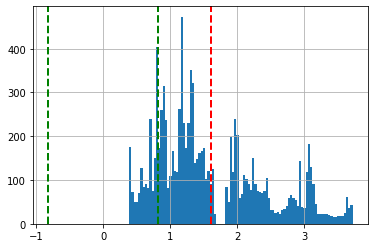

In [29]:
test_df['RV(WINDOW)'].hist(bins=100)
mean = test_df['RV(WINDOW)'].mean()
std  = test_df['RV(WINDOW)'].std()
plt.axvline(mean,color='red',linestyle='dashed',linewidth=2)
#to plot the std line we plot both the positive and negative values 
plt.axvline(std,color='g',linestyle='dashed',linewidth=2)
plt.axvline(-std,color='g',linestyle='dashed',linewidth=2)

In [30]:
test_df['RV(WINDOW)'].kurtosis()
#distribution is flatter than a normal curve with the same mean and standard deviation

-0.4491695805954241

#####  Forcasting Methods 

######  Autoregression Model

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. Parameters of the model:

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [31]:
df = test_df.copy()

In [32]:
df.shape

(11073, 25)

In [33]:
#window volalitily

![alt text](equation.png "Title")

In [34]:
# Voalatity to be predicted
# Leaving first WINDOW variables as they have NAN
y = test_df[WINDOW:]['RV(WINDOW)'] 
# Independent variables
X = test_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X = sm.add_constant(X) 

In [35]:
# Preparing Common Data from Autoression Model and OLS model
train_y = y[:-WINDOW]
train_X = X[:-WINDOW]
test_X  = X[-WINDOW:]
test_y  = y[-WINDOW:]
print("Training Data shape : ", train_X.shape, train_y.shape)
print("Testing  Data shape : ", test_X.shape, test_y.shape)

Training Data shape :  (10593, 24) (10593,)
Testing  Data shape :  (240, 24) (240,)


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

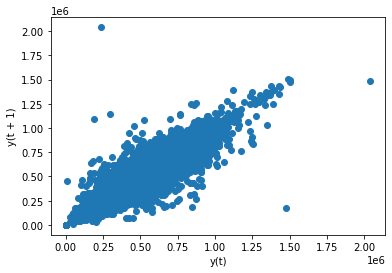

In [36]:
lag_plot(train_X)

In [37]:
# Preparing autoregression data
train_ar = train_X['Rt2']
test_ar  = test_X['Rt2'].values
LAGS     = 6

# Train autoregression
model = AutoReg(train_ar,lags=LAGS)
# Fit the unconditional maximum likelihood of an AR(p) process.
model_fit = model.fit()


In [38]:
window = LAGS#model_fit.ar_lags
coef = model_fit.params

In [39]:
history = train_ar[len(train_ar)-window:].values
history = [history[i] for i in range(len(history))]
# The list of predictions
predictions = list()

In [40]:
# Walk-forward validation
# Walk forward over time steps in test
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window, length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    # Store forecast
    predictions.append(yhat)
    history.append(obs)

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Mean Squared Error – átlagos négyzetes hiba
mse = mean_squared_error(test_ar, predictions)
print('MSE:  ' + str(mse))
# Mean Absolute Error
mae = mean_absolute_error(test_ar, predictions)
print('MAE:  ' + str(mae))
# Root Mean Squared Error - a MSE négyzetgyöke
rmse = math.sqrt(mean_squared_error(test_ar, predictions))
print('RMSE: ' + str(rmse))

MSE:  0.00014951172908537447
MAE:  0.009971620305126157
RMSE: 0.012227498889199478


#####  OLS Estimation of the importance of other features

![alt text](eq2.png "OLS")

In [42]:
# adding volatility variables

###### Using single lag of volatility

In [43]:
ols_df = test_df.copy()

In [44]:
y = ols_df[WINDOW:]['RV(WINDOW)'] 
# Independent variables
X = ols_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X = sm.add_constant(X) 

# Preparing Common Data from Autoression Model and OLS model
train_y = y[:-WINDOW]
train_X = X[:-WINDOW]
test_X  = X[-WINDOW:]
test_y  = y[-WINDOW:]

In [45]:
est = sm.OLS(train_y, train_X)

In [46]:
est = est.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             RV(WINDOW)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                 1.996e+04
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:43:41   Log-Likelihood:                 7112.3
No. Observations:               10593   AIC:                        -1.418e+04
Df Residuals:                   10570   BIC:                        -1.401e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.1246      0.099  

In [47]:
predictions = est.predict(test_X).values

In [48]:
MSE = mean_squared_error(test_y, predictions)
MAE = mean_absolute_error(test_y, predictions)

In [49]:
print("Mean Square Error :", MSE)
print("Mean Absolute Error :", MAE)

Mean Square Error : 0.004471675904867154
Mean Absolute Error : 0.055236406001380946


In [50]:
# P values illustrates the significance of different features.
est.pvalues

const                2.068146e-01
prices               8.637010e-01
ask                  1.850789e-03
bid                  3.976191e-05
vol                  2.836767e-49
logvoldiff           4.286916e-34
Rt                   8.408016e-01
Rt2                  2.023607e-25
daily_price_diff     3.209489e-01
obv                  3.540317e-01
pricesma2            2.310356e-02
pricesma3            7.881877e-01
pricesma9            2.175279e-10
pricesma12           1.927327e-27
pricesmo2           2.714752e-125
pricesmo3            9.488027e-51
pricesmo6            3.022919e-01
pricesmo9            2.247539e-26
pricesmo12           4.294065e-01
obv2                 1.858808e-74
obv3                5.151280e-106
obv6                 3.003329e-01
obv9                 3.856654e-09
obv12                6.008816e-05
dtype: float64

In [51]:
# These are the residuals, which we could manually add to our measured values to obtain the line of best fit
est.resid

240      0.610764
241      0.580885
242      0.594314
243      0.589650
244      0.586105
           ...   
10828   -0.118769
10829   -0.118537
10830   -0.119062
10831   -0.124068
10832   -0.129734
Length: 10593, dtype: float64

In [52]:
# from statsmodels.stats.outliers_influence import summary_table
# st, data, ss2 = summary_table(est, alpha=0.05)

In [53]:
# https://github.com/urschrei/linalg/blob/master/notebooks/ordinary_least_squares.ipynb

###### Using k Lags of volatility

In [54]:
ols_df = test_df[WINDOW:].copy()
y = ols_df[['RV(WINDOW)']]
y = y.reset_index()
y = y.drop(['index'], axis=1)

In [55]:
ols_df.shape

(10833, 25)

In [56]:
ind     = LAGS
columns = []


# creating k-lags columns
for _ in range(1,LAGS+1):
    columns.append('t-'+ str(_))
NEW_DATA = pd.DataFrame(columns=columns)
# filling nan for starting k lags values
for _ in range(LAGS+1):
    lag_data = []
    for __ in range(1,LAGS+1):
        lag_data.append(np.nan)
    NEW_DATA.loc[_] = lag_data
    
# appending k-previous lags values in a row
for row in y[LAGS:].iterrows():
    lag_data = []
    for lag in range(1,LAGS+1):
        lag_data.append(y.loc[row[0] - lag]['RV(WINDOW)'])
    NEW_DATA.loc[ind] = lag_data
    ind += 1

In [57]:
NEW_DATA = NEW_DATA.fillna(NEW_DATA.mean())

In [58]:
# ols_df = pd.concat([ols_df, NEW_DATA], axis=1)
for _ in range(1,LAGS+1):
    ols_df['t-'+ str(_)] = NEW_DATA['t-'+ str(_)].values

In [59]:
# y = ols_df[WINDOW:][['RV(WINDOW)']]
y = ols_df['RV(WINDOW)']
# y = y.reset_index()
# y = y.drop(['index'], axis=1)
# Independent variables
# X = ols_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
X = ols_df.drop(['RV(WINDOW)', 'date'], axis=1)
X = X.reset_index()
X = X.drop(['index'], axis=1)
X = X.fillna(X.mean())
y = y.fillna(y.mean())
X = sm.add_constant(X) 



In [60]:
# Preparing Common Data from Autoression Model and OLS model
train_y = y[:-WINDOW]
train_X = X[:-WINDOW]
test_X  = X[-WINDOW:]
test_y  = y[-WINDOW:]
train_X = train_X.reset_index()
train_y = train_y.reset_index()
train_X = train_X.drop(['index'], axis=1)
train_y = train_y.drop(['index'], axis=1)

In [62]:
est = sm.OLS(train_y, train_X)
est = est.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             RV(WINDOW)   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.625e+05
Date:                Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:44:00   Log-Likelihood:                 25954.
No. Observations:               10593   AIC:                        -5.185e+04
Df Residuals:                   10564   BIC:                        -5.164e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0274      0.017  

In [ ]:
# squaredbool, default=True
# If True returns MSE value, if False returns RMSE value.

In [63]:
predictions = est.predict(test_X).values
MSE         = mean_squared_error(test_y, predictions, squared=True)
RMSE        = mean_squared_error(test_y, predictions,squared=False)
MAE         = mean_absolute_error(test_y, predictions)
print("Root Mean Square Error :", RMSE)
print("Mean Square Error      :", MSE)
print("Mean Absolute Error    :", MAE)

Root Mean Square Error : 0.001322022083544916
Mean Square Error      : 1.7477423893804408e-06
Mean Absolute Error    : 0.0010488089909773124


In [ ]:
# https://github.com/jiwidi/time-series-forecasting-with-python/blob/master/03-Results_analysis%26discussion.ipynb

###### Shrinkage Approach (Lasso Regression) And Adaptive Lasso

In [ ]:
# https://machinelearningmastery.com/lasso-regression-with-python/
# https://alex.miller.im/posts/linear-model-custom-loss-function-regularization-python/

In [64]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [90]:
reg = Lasso(alpha=0.1)
reg.fit(train_X, train_y)
pred_train_lr= reg.predict(train_X)

MSE         = mean_squared_error(train_y, pred_train_lr, squared=True)
RMSE        = mean_squared_error(train_y, pred_train_lr,squared=False)
MAE         = mean_absolute_error(train_y, pred_train_lr)
print("Train")
print("Root Mean Square Error :", RMSE)
print("Mean Square Error      :", MSE)
print("Mean Absolute Error    :", MAE)
print("R2 Score               :", r2_score(train_y, pred_train_lr))

pred_test_lr= reg.predict(test_X)
MSE         = mean_squared_error(test_y, pred_test_lr, squared=True)
RMSE        = mean_squared_error(test_y, pred_test_lr,squared=False)
MAE         = mean_absolute_error(test_y, pred_test_lr)
print("Test")
print("Root Mean Square Error :", RMSE)
print("Mean Square Error      :", MSE)
print("Mean Absolute Error    :", MAE)
print("R2 Score               :", r2_score(test_y, pred_test_lr))



Train
Root Mean Square Error : 0.16585422093390575
Mean Square Error      : 0.02750762260159282
Mean Absolute Error    : 0.13140791398392943
R2 Score               : 0.957703427028217
Test
Root Mean Square Error : 0.08565823652908218
Mean Square Error      : 0.0073373334852721885
Mean Absolute Error    : 0.07131490881155628
R2 Score               : 0.41971136341570625


In [72]:
import numpy as np
import asgl
import sklearn.datasets

In [73]:
# Generate dataset
number_observations = 100
number_variables = 200
number_significant_variables = 10

x, y, true_beta = sklearn.datasets.make_regression(
  n_samples=number_observations, n_features=number_variables, 
  n_informative=number_significant_variables, n_targets=1, 
  bias=10.0, noise=1.0, shuffle=True, coef=True, random_state=1)

In [85]:
train_X.values.shape, train_y.values.shape, 


((10593, 30), (10593, 1))

In [98]:
train_y.values[:,0].shape

(10593,)

In [99]:
lambda1 = 10.0 ** np.arange(-3, 1.51, 0.1)

tvt_lasso = asgl.TVT(model='lm', penalization='lasso', lambda1=lambda1, parallel=True,
                     error_type='MSE', random_state=1)
lasso_result = tvt_lasso.train_validate_test(x=train_X.values, y=train_y.values[:,0])

lasso_prediction_error = lasso_result['test_error']
lasso_betas = lasso_result['optimal_betas'][1:] # Remove intercept

2022-01-04 12:50:51,193 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details


Lasso Error  0.0004873845443786343


In [106]:
tvt_alasso = asgl.TVT(model='lm', penalization='alasso', lambda1=lambda1, parallel=True,
                      weight_technique='lasso', error_type='MSE', random_state=1, 
                      train_size=80, validate_size=20)
alasso_result = tvt_alasso.train_validate_test(x=train_X.values, y=train_y.values[:,0])

alasso_prediction_error = alasso_result['test_error']
alasso_betas = alasso_result['optimal_betas'][1:] # Remove intercept

2022-01-04 12:51:58,115 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,118 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,119 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,120 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,121 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,120 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,124 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,127 - WARNING - Default solver failed. Using alte

/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-04 12:51:58,149 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details


/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-04 12:51:58,127 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,123 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,124 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details


/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be i

2022-01-04 12:51:58,129 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,128 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details
2022-01-04 12:51:58,171 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details


/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


2022-01-04 12:51:58,151 - WARNING - Default solver failed. Using alternative options. Check solver and solver_stats for more details


/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/cvxpy/problems/problem.py:1297: UserWarning: Solution may be i

In [108]:
print("Lasso Error          :", lasso_prediction_error)
print("Adaptive Lasso Error :", alasso_prediction_error) 

Lasso Error           0.0004873845443786343
Adaptive Lasso Error  0.020833750245858082


#####  Elastic Net

In [109]:
from sklearn.linear_model import ElasticNet

In [110]:
regr = ElasticNet(random_state=0)

In [111]:
regr.fit(train_X, train_y)

/home/minehunters/miniconda3/envs/tf/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e+03, tolerance: 6.889e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


ElasticNet(random_state=0)

In [113]:
predictions = regr.predict(test_X)
MSE         = mean_squared_error(test_y, predictions, squared=True)
RMSE        = mean_squared_error(test_y, predictions,squared=False)
MAE         = mean_absolute_error(test_y, predictions)
print("Test")
print("Root Mean Square Error :", RMSE)
print("Mean Square Error      :", MSE)
print("Mean Absolute Error    :", MAE)
print("R2 Score               :", r2_score(test_y, predictions))


Test
Root Mean Square Error : 0.3780400595261236
Mean Square Error      : 0.14291428660651503
Mean Absolute Error    : 0.36146595613679555
R2 Score               : -10.30268055687742


#### API

In [ ]:
AVAILABLE_CRYPTOS = list(prices_df.columns)
AVAILABLE_CRYPTOS.remove('bake')
AVAILABLE_CRYPTOS.remove('alice')
# these cryptos have majority of Nan values

In [ ]:
CRYPTO       = '1inch'
assert CRYPTO in AVAILABLE_CRYPTOS
PRICE_INPUT  = prices_df[CRYPTO]
BID_INPUT    = bid_df[CRYPTO]
ASK_INPUT    = ask_df[CRYPTO]
WINDOW       = 240
LAGS         = 6

In [ ]:
def preprocessing(PRICE_INPUT, BID_INPUT, ASK_INPUT):
    test_df = pd.DataFrame()
    test_df['date']             = prices_df['datetime']
    test_df['prices']           = PRICE_INPUT
    test_df['ask']              = ASK_INPUT
    test_df['bid']              = BID_INPUT
    test_df['vol']              = 0.5 * (test_df['ask'] + test_df['bid'])
    test_df['logvoldiff']       = logvoldiff_df['1inch']
    test_df['Rt']               = np.log(test_df['prices'].rolling(2).mean())
    test_df['Rt2']              = test_df['Rt'] * test_df['Rt']
    test_df['RV(WINDOW)']       = test_df['Rt2'].rolling(WINDOW).mean()
    test_df['daily_price_diff'] = test_df['prices'] - test_df['prices'].shift(1)
    test_df['obv']              = test_df[['daily_price_diff']][1:].apply(lambda x: 1 if x['daily_price_diff']>0 \
                                                                          else 0, axis=1) * test_df['Rt']

    # Moving Average ( s = 1,2,3), l = (9,12)
    test_df['pricesma2']   = test_df['prices'].rolling(2).mean()
    test_df['pricesma3']   = test_df['prices'].rolling(3).mean()
    test_df['pricesma9']   = test_df['prices'].rolling(9).mean()
    test_df['pricesma12']   = test_df['prices'].rolling(12).mean()
    # Momentum Signal is computed monthly so analogoues to our use case, compunting it in windows.
    # ( s = 1,2,3), l = (9,12)
    test_df['pricesmo2']   = test_df['prices'].rolling(WINDOW * 2).mean()
    test_df['pricesmo3']   = test_df['prices'].rolling(WINDOW * 3).mean()
    test_df['pricesmo6']   = test_df['prices'].rolling(WINDOW * 6).mean()
    test_df['pricesmo9']   = test_df['prices'].rolling(WINDOW * 9).mean()
    test_df['pricesmo12']   = test_df['prices'].rolling(WINDOW * 12).mean()
    #On Balance Volume ( s = 1,2,3), l = (9,12)
    test_df['obv2']        = test_df['obv'].rolling(WINDOW * 2).mean()
    test_df['obv3']        = test_df['obv'].rolling(WINDOW * 3).mean()
    test_df['obv6']        = test_df['obv'].rolling(WINDOW * 6).mean()
    test_df['obv9']        = test_df['obv'].rolling(WINDOW * 9).mean()
    test_df['obv12']        = test_df['obv'].rolling(WINDOW * 12).mean()
    
    return test_df

In [ ]:
def train_test_split(test_df): 
    # Voalatity to be predicted
    # Leaving first WINDOW variables as they have NAN
    y = test_df[WINDOW:]['RV(WINDOW)'] 
    # Independent variables
    X = test_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    X = sm.add_constant(X) 

    # Preparing Common Data from Autoression Model and OLS model
    train_y = y[:-WINDOW]
    train_X = X[:-WINDOW]
    test_X  = X[-WINDOW:]
    test_y  = y[-WINDOW:]
    print("Training Data shape : ", train_X.shape, train_y.shape)
    print("Testing  Data shape : ", test_X.shape, test_y.shape)
    
    return train_y, train_X,test_X ,test_y

In [ ]:
def AR_MODEL(train_ar,test_ar, LAGS, save_model = False, return_model = False):
    model     = AutoReg(train_ar,lags=LAGS)
    model_fit = model.fit()
    window    = LAGS
    coef      = model_fit.params
    history   = train_ar[len(train_ar)-window:]
    history   = [history[i] for i in range(len(history))]
    # The list of predictions
    predictions = list()

    # Walk-forward validation
    # Walk forward over time steps in test
    for t in range(len(test_ar)):
        length = len(history)
        lag = [history[i] for i in range(length-window, length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test_ar[t]
        # Store forecast
        predictions.append(yhat)
        history.append(obs)
    
        # Mean Squared Error – átlagos négyzetes hiba
    mse = mean_squared_error(test_ar, predictions)
    print('MSE:  ' + str(mse))
    # Mean Absolute Error
    mae = mean_absolute_error(test_ar, predictions)
    print('MAE:  ' + str(mae))
    # Root Mean Squared Error - a MSE négyzetgyöke
    rmse = math.sqrt(mean_squared_error(test_ar, predictions))
    print('RMSE: ' + str(rmse))
    
    if save_model:
        dump(model, open('AR_MODEL.pkl', 'wb'))
    
    if return_model:
        return model     

In [ ]:
exp_df = preprocessing(PRICE_INPUT, BID_INPUT, ASK_INPUT)

In [ ]:
train_y, train_X,test_X ,test_y = train_test_split(exp_df)

In [ ]:
AR_MODEL(train_y.values, test_y.values, LAGS)

In [ ]:
def OLS_1_LAG(ols_df, save_model = False, return_model = False):
    y = ols_df[WINDOW:]['RV(WINDOW)'] 
    # Independent variables
    X = ols_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    X = sm.add_constant(X) 

    # Preparing Common Data from Autoression Model and OLS model
    train_y = y[:-WINDOW]
    train_X = X[:-WINDOW]
    test_X  = X[-WINDOW:]
    test_y  = y[-WINDOW:]
    
    print(y.shape)
    
    est = sm.OLS(train_y, train_X)
    
    est = est.fit()
    print(est.summary())
    
    predictions = est.predict(test_X).values
    MSE  = mean_squared_error(test_y, predictions, squared=True)
    RMSE = mean_squared_error(test_y, predictions, squared=False)
    MAE  = mean_absolute_error(test_y, predictions)
    print('\n')
    print("Root Mean Square Error :", RMSE)
    print("Mean Square Error      :", MSE)
    print("Mean Absolute Error    :", MAE)
    
    
    if save_model:
        dump(model, open('OLS_k_Lags.pkl', 'wb'))
    if return_model:
        return model    

In [ ]:
OLS_1_LAG(exp_df)

In [ ]:
# def OLS(ols_df):
    
#     y = ols_df[WINDOW:]['RV(WINDOW)'] 
#     y = y.fillna(y.mean())
#     y = y.reset_index()
#     y = y.drop(['index'], axis=1)
    
#     ind     = 0
#     columns = []
#     for _ in range(LAGS):
#         columns.append('t-'+ str(_))
#     NEW_DATA = pd.DataFrame(columns=columns)
#     for row in y[LAGS:].iterrows():
#         lag_data = []
#         for lag in range(LAGS):
#             lag_data.append(y.loc[row[0] - lag]['RV(WINDOW)'])
#         NEW_DATA.loc[ind] = lag_data
#         ind += 1
        
#     ols_df = pd.concat([ols_df, NEW_DATA], axis=1)
    
    
#     # Independent variables
#     X = ols_df[WINDOW:].drop(['RV(WINDOW)', 'date'], axis=1)
#     X = X.fillna(X.mean())
    
# #     X = sm.add_constant(X) 

#     # Preparing Common Data from Autoression Model and OLS model
#     train_y = y[:-WINDOW]
#     train_X = X[:-WINDOW]
#     test_X  = X[-WINDOW:]
#     test_y  = y[-WINDOW:]
#     train_X = train_X.reset_index()
#     train_y = train_y.reset_index()
#     train_X = train_X.drop(['index'], axis=1)
#     train_y = train_y.drop(['index'], axis=1)
    
#     est = sm.OLS(train_y, train_X)
    
#     est = est.fit()
#     print(est.summary())
    
    
#     predictions = est.predict(test_X).values
#     MSE  = mean_squared_error(test_y, predictions, squared=True)
#     RMSE = mean_squared_error(test_y, predictions,squared=False)
#     MAE  = mean_absolute_error(test_y, predictions)
    
#     print('\n')
#     print("Root Mean Square Error :", RMSE)
#     print("Mean Square Error      :", MSE)
#     print("Mean Absolute Error    :", MAE)
# OLS(exp_df)

In [ ]:
def OLS(test_df, save_model = False, return_model = False):
    ols_df = test_df[WINDOW:].copy()
    y = ols_df[['RV(WINDOW)']]
    y = y.reset_index()
    y = y.drop(['index'], axis=1)
    
    ind     = LAGS
    columns = []

    # creating k-lags columns
    for _ in range(1,LAGS+1):
        columns.append('t-'+ str(_))
    NEW_DATA = pd.DataFrame(columns=columns)
    # filling nan for starting k lags values
    for _ in range(LAGS+1):
        lag_data = []
        for __ in range(1,LAGS+1):
            lag_data.append(np.nan)
        NEW_DATA.loc[_] = lag_data

    # appending k-previous lags values in a row
    for row in y[LAGS:].iterrows():
        lag_data = []
        for lag in range(1,LAGS+1):
            lag_data.append(y.loc[row[0] - lag]['RV(WINDOW)'])
        NEW_DATA.loc[ind] = lag_data
        ind += 1
        
    NEW_DATA = NEW_DATA.fillna(NEW_DATA.mean())
    
    # ols_df = pd.concat([ols_df, NEW_DATA], axis=1)
    for _ in range(1,LAGS+1):
        ols_df['t-'+ str(_)] = NEW_DATA['t-'+ str(_)].values

        # y = ols_df[WINDOW:][['RV(WINDOW)']]
    y = ols_df['RV(WINDOW)']
    X = ols_df.drop(['RV(WINDOW)', 'date'], axis=1)
    X = X.reset_index()
    X = X.drop(['index'], axis=1)
    X = X.fillna(X.mean())
    y = y.fillna(y.mean())
    X = sm.add_constant(X) 
    
    # Preparing Common Data from Autoression Model and OLS model
    train_y = y[:-WINDOW]
    train_X = X[:-WINDOW]
    test_X  = X[-WINDOW:]
    test_y  = y[-WINDOW:]
    train_X = train_X.reset_index()
    train_y = train_y.reset_index()
    train_X = train_X.drop(['index'], axis=1)
    train_y = train_y.drop(['index'], axis=1)
    est = sm.OLS(train_y, train_X)
    est = est.fit()
    print(est.summary())
    
    predictions = est.predict(test_X).values
    MSE  = mean_squared_error(test_y, predictions, squared=True)
    RMSE = mean_squared_error(test_y, predictions,squared=False)
    MAE  = mean_absolute_error(test_y, predictions)
    print('\n')
    print("Root Mean Square Error :", RMSE)
    print("Mean Square Error      :", MSE)
    print("Mean Absolute Error    :", MAE)
    
    
    if save_model:
        dump(model, open('OLS_k_Lags.pkl', 'wb'))
    if return_model:
        return model     

In [ ]:
OLS(exp_df)